In [1]:
import sys
import os
from math import log
import numpy as np
import seaborn as sns
import pandas as pd
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import cv2 as cv
import pickle
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score, auc

np.random.seed(72)
tf.random.set_seed(72)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

C:\Users\HSSL77\anaconda3\envs\tf_gpu_final\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6



In [2]:
def get_train_test(train_dir, test_dir):
    datagen_train = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1,
                                      horizontal_flip=True,  vertical_flip=False)
    datagen_test = ImageDataGenerator(rescale=1./255)

    generator_train = datagen_train.flow_from_directory(directory=train_dir, target_size=(image_size, image_size),
                                                        batch_size=batch_size, shuffle=True)
    generator_test = datagen_test.flow_from_directory(directory=test_dir, target_size=(image_size, image_size),
                                                      batch_size=batch_size, shuffle=False)

    num_classes = generator_train.num_classes
    labels = generator_train.classes
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
    class_weights = dict(zip(np.unique(labels), class_weights))
    print(class_weights)
    
    steps_per_epoch = generator_train.n / batch_size
    steps_test = generator_test.n / batch_size
    return generator_train, generator_test, labels, class_weights, num_classes, steps_per_epoch, steps_test

def compile_model(model, weight):
    optimizer = Adam(lr=1e-5) 
    loss = 'categorical_crossentropy'

    metrics = ['accuracy', 'categorical_accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
               tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), 
               tf.keras.metrics.FalseNegatives(), tfa.metrics.CohenKappa(num_classes = num_classes), 
               tfa.metrics.F1Score(num_classes = num_classes)]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1,
        patience=9, mode="max", min_delta=0.0001, min_lr=0.00001, verbose=1)
    checkpoint = ModelCheckpoint(filepath=weight, save_best_only=True, monitor = 'val_accuracy', verbose=1)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)

    callbacks = [lr, checkpoint, early_stopping]
    return model, callbacks

def evaluate_(model, generator_test):
    model.evaluate(generator_test)
    
    y_pred = model.predict(generator_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())

    print(classification_report(y_true, y_pred_classes))
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.show()
    
def plot_graphs(history, generator_test):
    plt.figure(figsize=(15,7))
    plt.plot(history.history['accuracy'], 'r', linewidth=2.5)
    plt.plot(history.history['val_accuracy'], linewidth=2.5)
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='upper left')
    plt.show()

    plt.figure(figsize=(15,7))
    plt.plot(history.history['loss'], 'r', linewidth=2.5)
    plt.plot(history.history['val_loss'], linewidth=2.5)
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper left')
    plt.show()
    
    # Generate predictions
    predictions = model.predict_generator(generator_test)
    # Get true labels
    true_labels = generator_test.classes
    # Binarize the true labels
    encoder = OneHotEncoder(sparse=False)
    true_labels = encoder.fit_transform(true_labels.reshape(-1, 1))
    # Calculate ROC curve and ROC AUC for each class
    n_classes = true_labels.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for class_idx in range(n_classes):
        fpr[class_idx], tpr[class_idx], _ = roc_curve(true_labels[:, class_idx], predictions[:, class_idx])
        roc_auc[class_idx] = auc(fpr[class_idx], tpr[class_idx])

    # Plot ROC curves for each class
    plt.figure(figsize=(12, 12))
    for class_idx in range(n_classes):

        plt.plot(fpr[class_idx], tpr[class_idx], label='ROC curve (area = %0.2f) for class %d' % (roc_auc[class_idx], class_idx),
                linewidth=2.5)

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic per Class')
    plt.legend(loc='lower right')
    plt.show()

In [3]:
# Params
num_classes = 2
batch_size = 8
image_size = 112
weight = 'MaxVIT.h5'

In [4]:
from keras_cv_attention_models import maxvit
model = maxvit.MaxViT_Tiny(input_shape=(image_size, image_size, 3) , num_classes=num_classes, 
                         drop_connect_rate=0.2, classifier_activation="softmax")

>>>> Load pretrained from: C:\Users\HSSL77\.keras\models\maxvit_tiny_224_imagenet.h5
>>>> Reload mismatched weights: 224 -> (112, 112)
>>>> Reload layer: stack_1_block_1/block_window_mhsa/pos_emb
>>>> Reload layer: stack_1_block_1/grid_window_mhsa/pos_emb
>>>> Reload layer: stack_1_block_2/block_window_mhsa/pos_emb
>>>> Reload layer: stack_1_block_2/grid_window_mhsa/pos_emb
>>>> Reload layer: stack_2_block_1/block_window_mhsa/pos_emb
>>>> Reload layer: stack_2_block_1/grid_window_mhsa/pos_emb
>>>> Reload layer: stack_2_block_2/block_window_mhsa/pos_emb
>>>> Reload layer: stack_2_block_2/grid_window_mhsa/pos_emb
>>>> Reload layer: stack_3_block_1/block_window_mhsa/pos_emb
>>>> Reload layer: stack_3_block_1/grid_window_mhsa/pos_emb
>>>> Reload layer: stack_3_block_2/block_window_mhsa/pos_emb
>>>> Reload layer: stack_3_block_2/grid_window_mhsa/pos_emb
>>>> Reload layer: stack_3_block_3/block_window_mhsa/pos_emb
>>>> Reload layer: stack_3_block_3/grid_window_mhsa/pos_emb
>>>> Reload layer:

## Original

In [7]:
train_dir = r"D:\Personal\Ocular Toxoplasmosis\data\BinaryClassification\train"
test_dir = r"D:\Personal\Ocular Toxoplasmosis\data\BinaryClassification\val"
generator_train, generator_test, labels, class_weights, num_classes, steps_per_epoch, steps_test = get_train_test(train_dir, test_dir)
model, callbacks = compile_model(model, weight)

Found 366 images belonging to 2 classes.
Found 83 images belonging to 2 classes.
{0: 1.3863636363636365, 1: 0.782051282051282}


C:\Users\HSSL77\anaconda3\envs\tf_gpu_final\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
epochs = 50
history = model.fit_generator(generator=generator_train, epochs=epochs,steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test, validation_steps=steps_test,
                                 callbacks= callbacks, class_weight =class_weights)

C:\Users\HSSL77\AppData\Local\Temp\ipykernel_12164\1010306549.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=generator_train, epochs=epochs,steps_per_epoch=steps_per_epoch,


Epoch 1/50
46/45 [==============================] - ETA: 0s - loss: 0.8420 - accuracy: 0.4536 - categorical_accuracy: 0.4536 - auc: 0.4484 - precision: 0.4536 - recall: 0.4536 - true_positives: 166.0000 - true_negatives: 166.0000 - false_positives: 200.0000 - false_negatives: 200.0000 - cohen_kappa: -0.9542 - f1_score: 0.4405

C:\Users\HSSL77\anaconda3\envs\tf_gpu_final\lib\site-packages\keras\engine\training.py:2034: UserWarning: Metric CohenKappa implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
C:\Users\HSSL77\anaconda3\envs\tf_gpu_final\lib\site-packages\keras\engine\training.py:2034: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_accuracy improved from -inf to 0.50602, saving model to MaxVIT.h5
45/45 [==============================] - 78s 581ms/step - loss: 0.8420 - accuracy: 0.4536 - categorical_accuracy: 0.4536 - auc: 0.4484 - precision: 0.4536 - recall: 0.4536 - true_positives: 166.0000 - true_negatives: 166.0000 - false_positives: 200.0000 - false_negatives: 200.0000 - cohen_kappa: -0.9542 - f1_score: 0.4405 - val_loss: 0.7414 - val_accuracy: 0.5060 - val_categorical_accuracy: 0.5060 - val_auc: 0.4386 - val_precision: 0.5060 - val_recall: 0.5060 - val_true_positives: 42.0000 - val_true_negatives: 42.0000 - val_false_positives: 41.0000 - val_false_negatives: 41.0000 - val_cohen_kappa: -0.9988 - val_f1_score: 0.5057 - lr: 1.0000e-05
Epoch 2/50
46/45 [==============================] - ETA: 0s - loss: 0.6436 - accuracy: 0.5956 - categorical_accuracy: 0.5956 - auc: 0.6715 - precision: 0.5956 - recall: 0.5956 - true_positives: 218.0000 - true_negatives: 218.0000 - false_positives: 148.0000 - false_n

Epoch 17/50
46/45 [==============================] - ETA: 0s - loss: 0.1695 - accuracy: 0.9536 - categorical_accuracy: 0.9536 - auc: 0.9820 - precision: 0.9536 - recall: 0.9536 - true_positives: 349.0000 - true_negatives: 349.0000 - false_positives: 17.0000 - false_negatives: 17.0000 - cohen_kappa: -0.8836 - f1_score: 0.9505
Epoch 17: val_accuracy did not improve from 0.85542
45/45 [==============================] - 15s 316ms/step - loss: 0.1695 - accuracy: 0.9536 - categorical_accuracy: 0.9536 - auc: 0.9820 - precision: 0.9536 - recall: 0.9536 - true_positives: 349.0000 - true_negatives: 349.0000 - false_positives: 17.0000 - false_negatives: 17.0000 - cohen_kappa: -0.8836 - f1_score: 0.9505 - val_loss: 0.4059 - val_accuracy: 0.8313 - val_categorical_accuracy: 0.8313 - val_auc: 0.9008 - val_precision: 0.8313 - val_recall: 0.8313 - val_true_positives: 69.0000 - val_true_negatives: 69.0000 - val_false_positives: 14.0000 - val_false_negatives: 14.0000 - val_cohen_kappa: -0.9195 - val_f1_s

Epoch 25/50
46/45 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.9617 - categorical_accuracy: 0.9617 - auc: 0.9870 - precision: 0.9617 - recall: 0.9617 - true_positives: 352.0000 - true_negatives: 352.0000 - false_positives: 14.0000 - false_negatives: 14.0000 - cohen_kappa: -0.8713 - f1_score: 0.9589
Epoch 25: val_accuracy did not improve from 0.90361
45/45 [==============================] - 17s 373ms/step - loss: 0.1296 - accuracy: 0.9617 - categorical_accuracy: 0.9617 - auc: 0.9870 - precision: 0.9617 - recall: 0.9617 - true_positives: 352.0000 - true_negatives: 352.0000 - false_positives: 14.0000 - false_negatives: 14.0000 - cohen_kappa: -0.8713 - f1_score: 0.9589 - val_loss: 0.3528 - val_accuracy: 0.9036 - val_categorical_accuracy: 0.9036 - val_auc: 0.9252 - val_precision: 0.9036 - val_recall: 0.9036 - val_true_positives: 75.0000 - val_true_negatives: 75.0000 - val_false_positives: 8.0000 - val_false_negatives: 8.0000 - val_cohen_kappa: -0.8797 - val_f1_sco

Epoch 33/50
46/45 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.9754 - categorical_accuracy: 0.9754 - auc: 0.9954 - precision: 0.9754 - recall: 0.9754 - true_positives: 357.0000 - true_negatives: 357.0000 - false_positives: 9.0000 - false_negatives: 9.0000 - cohen_kappa: -0.8687 - f1_score: 0.9736
Epoch 33: val_accuracy did not improve from 0.90361
45/45 [==============================] - 17s 370ms/step - loss: 0.0822 - accuracy: 0.9754 - categorical_accuracy: 0.9754 - auc: 0.9954 - precision: 0.9754 - recall: 0.9754 - true_positives: 357.0000 - true_negatives: 357.0000 - false_positives: 9.0000 - false_negatives: 9.0000 - cohen_kappa: -0.8687 - f1_score: 0.9736 - val_loss: 0.3423 - val_accuracy: 0.8916 - val_categorical_accuracy: 0.8916 - val_auc: 0.9329 - val_precision: 0.8916 - val_recall: 0.8916 - val_true_positives: 74.0000 - val_true_negatives: 74.0000 - val_false_positives: 9.0000 - val_false_negatives: 9.0000 - val_cohen_kappa: -0.8902 - val_f1_score: 

Epoch 41/50
46/45 [==============================] - ETA: 0s - loss: 0.0450 - accuracy: 0.9836 - categorical_accuracy: 0.9836 - auc: 0.9993 - precision: 0.9836 - recall: 0.9836 - true_positives: 360.0000 - true_negatives: 360.0000 - false_positives: 6.0000 - false_negatives: 6.0000 - cohen_kappa: -0.8611 - f1_score: 0.9823
Epoch 41: val_accuracy did not improve from 0.90361
45/45 [==============================] - 18s 386ms/step - loss: 0.0450 - accuracy: 0.9836 - categorical_accuracy: 0.9836 - auc: 0.9993 - precision: 0.9836 - recall: 0.9836 - true_positives: 360.0000 - true_negatives: 360.0000 - false_positives: 6.0000 - false_negatives: 6.0000 - cohen_kappa: -0.8611 - f1_score: 0.9823 - val_loss: 0.4033 - val_accuracy: 0.8795 - val_categorical_accuracy: 0.8795 - val_auc: 0.9250 - val_precision: 0.8795 - val_recall: 0.8795 - val_true_positives: 73.0000 - val_true_negatives: 73.0000 - val_false_positives: 10.0000 - val_false_negatives: 10.0000 - val_cohen_kappa: -0.9004 - val_f1_score

Epoch 49/50
46/45 [==============================] - ETA: 0s - loss: 0.0573 - accuracy: 0.9754 - categorical_accuracy: 0.9754 - auc: 0.9983 - precision: 0.9754 - recall: 0.9754 - true_positives: 357.0000 - true_negatives: 357.0000 - false_positives: 9.0000 - false_negatives: 9.0000 - cohen_kappa: -0.8636 - f1_score: 0.9735
Epoch 49: val_accuracy did not improve from 0.90361
45/45 [==============================] - 18s 384ms/step - loss: 0.0573 - accuracy: 0.9754 - categorical_accuracy: 0.9754 - auc: 0.9983 - precision: 0.9754 - recall: 0.9754 - true_positives: 357.0000 - true_negatives: 357.0000 - false_positives: 9.0000 - false_negatives: 9.0000 - cohen_kappa: -0.8636 - f1_score: 0.9735 - val_loss: 0.3500 - val_accuracy: 0.8795 - val_categorical_accuracy: 0.8795 - val_auc: 0.9457 - val_precision: 0.8795 - val_recall: 0.8795 - val_true_positives: 73.0000 - val_true_negatives: 73.0000 - val_false_positives: 10.0000 - val_false_negatives: 10.0000 - val_cohen_kappa: -0.9004 - val_f1_score

11/11 [==============================] - 8s 183ms/step - loss: 0.3570 - accuracy: 0.9036 - categorical_accuracy: 0.9036 - auc: 0.9235 - precision: 0.9036 - recall: 0.9036 - true_positives: 75.0000 - true_negatives: 75.0000 - false_positives: 8.0000 - false_negatives: 8.0000 - cohen_kappa: -0.8797 - f1_score: 0.8970
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        27
           1       1.00      0.86      0.92        56

    accuracy                           0.90        83
   macro avg       0.89      0.93      0.90        83
weighted avg       0.93      0.90      0.91        83



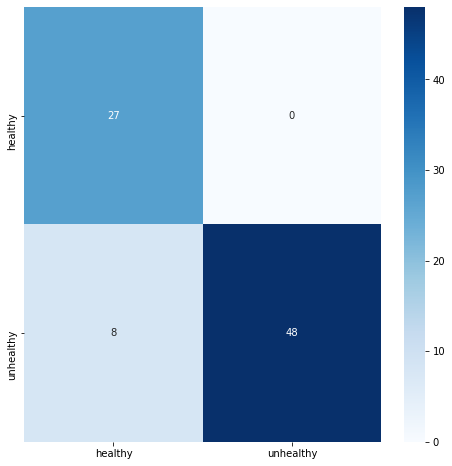

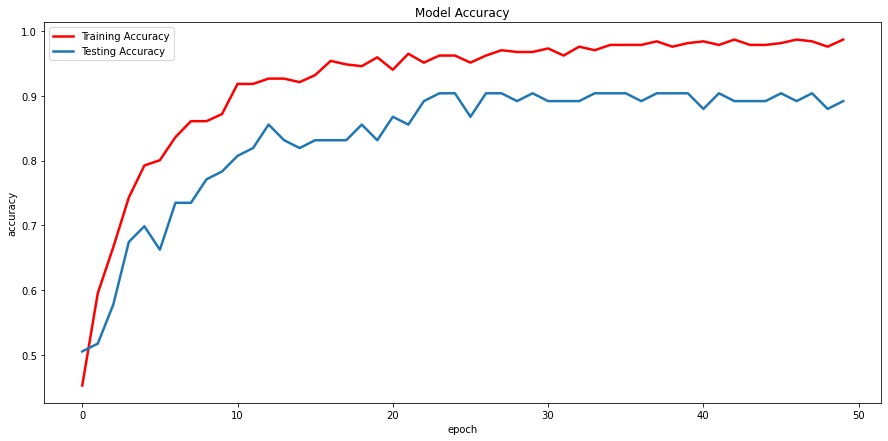

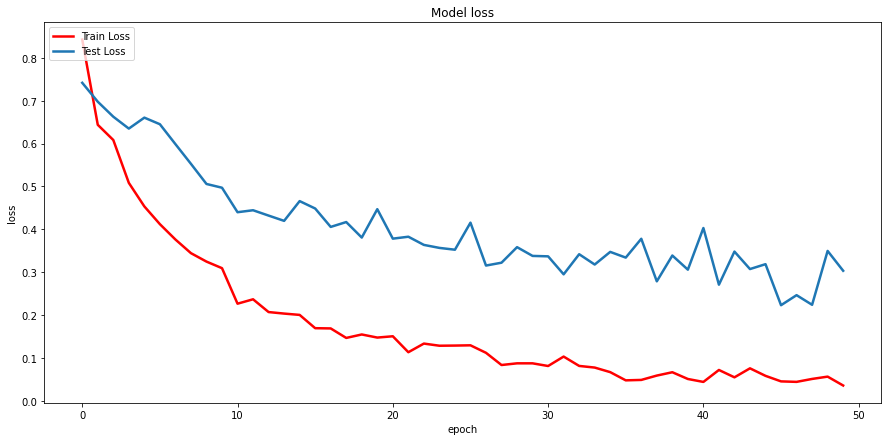

C:\Users\HSSL77\AppData\Local\Temp\ipykernel_12164\3330063544.py:38: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator_test)


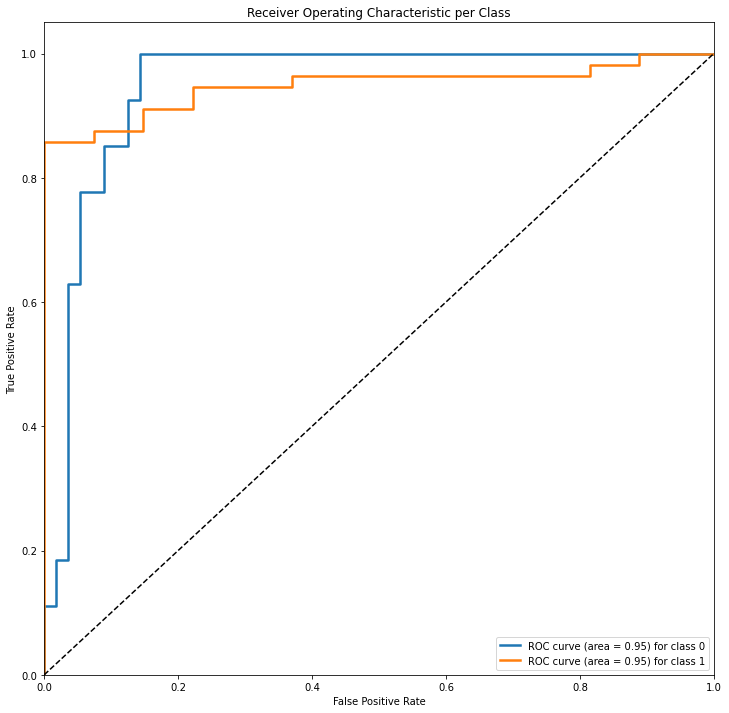

In [8]:
model = keras.models.load_model(weight)
evaluate_(model, generator_test)
plot_graphs(history, generator_test)